In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sea
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import xgboost as xgb
import tensorflow as tf

In [2]:
df = pd.read_csv('SolAtasIMC_tratado.csv')

Imprimimos la información general de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36400 entries, 0 to 36399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    36400 non-null  object 
 1   open    36400 non-null  float64
 2   high    36400 non-null  float64
 3   low     36400 non-null  float64
 4   close   36400 non-null  float64
 5   value   36400 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.7+ MB


In [4]:
tamanio = df.shape[0]

Creamos los conjuntos de entrenamiento, validación y test

In [5]:
df_train = df.copy().loc[0:int(tamanio*0.7)]
df_train

,date,open,high,low,close,value
0,2020-08-12 03:00:00,3.10,3.35,3.10,3.25,75
1,2020-08-12 04:00:00,3.25,3.25,3.15,3.15,75
2,2020-08-12 05:00:00,3.15,3.30,3.15,3.30,75
3,2020-08-12 06:00:00,3.30,3.30,3.15,3.30,75
4,2020-08-12 07:00:00,3.25,3.25,3.20,3.25,75
...,...,...,...,...,...,...
25476,2023-07-11 21:00:00,22.00,22.05,21.90,22.00,57
25477,2023-07-11 22:00:00,22.00,22.10,21.90,22.00,57
25478,2023-07-11 23:00:00,22.00,22.05,21.75,21.95,57
25479,2023-07-12 00:00:00,21.95,22.10,21.90,22.05,64


In [6]:
df_vali = df.copy().loc[int(tamanio*0.7 + 1):int(tamanio*0.9)]
df_vali

,date,open,high,low,close,value
25481,2023-07-12 02:00:00,22.10,22.30,22.05,22.15,64
25482,2023-07-12 03:00:00,22.15,22.25,22.10,22.10,64
25483,2023-07-12 04:00:00,22.10,22.10,22.00,22.00,64
25484,2023-07-12 05:00:00,22.00,22.00,21.90,21.95,64
25485,2023-07-12 06:00:00,21.95,22.05,21.90,22.00,64
...,...,...,...,...,...,...
32756,2024-05-10 05:00:00,153.65,154.35,152.85,153.95,66
32757,2024-05-10 06:00:00,153.95,154.70,153.45,153.75,66
32758,2024-05-10 07:00:00,153.75,154.10,152.30,153.30,66
32759,2024-05-10 08:00:00,153.30,155.10,153.15,154.95,66


In [7]:
df_test = df.copy().loc[int(tamanio*0.9 + 1):tamanio]
df_test

,date,open,high,low,close,value
32761,2024-05-10 10:00:00,154.35,154.5,153.45,154.10,66
32762,2024-05-10 11:00:00,154.10,154.8,153.25,154.15,66
32763,2024-05-10 12:00:00,154.15,154.3,153.25,154.15,66
32764,2024-05-10 13:00:00,154.15,155.2,153.00,155.05,66
32765,2024-05-10 14:00:00,155.05,155.4,153.10,153.30,66
...,...,...,...,...,...,...
36395,2024-10-08 20:00:00,143.35,143.9,142.35,142.95,49
36396,2024-10-08 21:00:00,142.95,144.1,142.25,143.75,49
36397,2024-10-08 22:00:00,143.75,144.5,143.35,144.50,49
36398,2024-10-08 23:00:00,144.50,144.7,144.05,144.25,49


Declaramos el modelo RandomForestRegressor

Preparamos los datos en el formato necesario para entrenar el algoritmo

# Entrenamos un modelo de red neuronal

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [9]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps, 3])  
    return np.array(X), np.array(y)
df_train_aux = df_train[['open', 'high', 'low', 'close', 'value']].values
X_train, y_train= create_sequences(df_train_aux, 7)
X_train

array([[[ 3.1 ,  3.35,  3.1 ,  3.25, 75.  ],
        [ 3.25,  3.25,  3.15,  3.15, 75.  ],
        [ 3.15,  3.3 ,  3.15,  3.3 , 75.  ],
        ...,
        [ 3.25,  3.25,  3.2 ,  3.25, 75.  ],
        [ 3.25,  3.3 ,  3.15,  3.25, 75.  ],
        [ 3.25,  3.4 ,  3.25,  3.4 , 75.  ]],

       [[ 3.25,  3.25,  3.15,  3.15, 75.  ],
        [ 3.15,  3.3 ,  3.15,  3.3 , 75.  ],
        [ 3.3 ,  3.3 ,  3.15,  3.3 , 75.  ],
        ...,
        [ 3.25,  3.3 ,  3.15,  3.25, 75.  ],
        [ 3.25,  3.4 ,  3.25,  3.4 , 75.  ],
        [ 3.35,  3.55,  3.35,  3.45, 75.  ]],

       [[ 3.15,  3.3 ,  3.15,  3.3 , 75.  ],
        [ 3.3 ,  3.3 ,  3.15,  3.3 , 75.  ],
        [ 3.25,  3.25,  3.2 ,  3.25, 75.  ],
        ...,
        [ 3.25,  3.4 ,  3.25,  3.4 , 75.  ],
        [ 3.35,  3.55,  3.35,  3.45, 75.  ],
        [ 3.45,  3.7 ,  3.4 ,  3.7 , 75.  ]],

       ...,

       [[22.1 , 22.4 , 21.95, 22.2 , 57.  ],
        [22.2 , 22.25, 21.9 , 22.15, 57.  ],
        [22.15, 22.2 , 21.95, 22.1 , 57.  

In [10]:
df_vali_aux = df_vali[['open', 'high', 'low', 'close', 'value']].values
X_vali, y_vali= create_sequences(df_vali_aux, 7)
X_vali

array([[[ 22.1 ,  22.3 ,  22.05,  22.15,  64.  ],
        [ 22.15,  22.25,  22.1 ,  22.1 ,  64.  ],
        [ 22.1 ,  22.1 ,  22.  ,  22.  ,  64.  ],
        ...,
        [ 21.95,  22.05,  21.9 ,  22.  ,  64.  ],
        [ 22.  ,  22.1 ,  22.  ,  22.05,  64.  ],
        [ 22.  ,  22.2 ,  22.  ,  22.05,  64.  ]],

       [[ 22.15,  22.25,  22.1 ,  22.1 ,  64.  ],
        [ 22.1 ,  22.1 ,  22.  ,  22.  ,  64.  ],
        [ 22.  ,  22.  ,  21.9 ,  21.95,  64.  ],
        ...,
        [ 22.  ,  22.1 ,  22.  ,  22.05,  64.  ],
        [ 22.  ,  22.2 ,  22.  ,  22.05,  64.  ],
        [ 22.05,  22.15,  22.  ,  22.05,  64.  ]],

       [[ 22.1 ,  22.1 ,  22.  ,  22.  ,  64.  ],
        [ 22.  ,  22.  ,  21.9 ,  21.95,  64.  ],
        [ 21.95,  22.05,  21.9 ,  22.  ,  64.  ],
        ...,
        [ 22.  ,  22.2 ,  22.  ,  22.05,  64.  ],
        [ 22.05,  22.15,  22.  ,  22.05,  64.  ],
        [ 22.05,  22.05,  21.95,  22.05,  64.  ]],

       ...,

       [[150.35, 153.4 , 150.15, 152.95,  

In [11]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(35,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mape')

C:\Users\raulg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
X_trainR = []
for i in X_train:
    aux = []
    for r in range(0, 7):
        for elem in i[r]:
            aux.append(elem)
    X_trainR.append(aux)       
X_trainR = np.array(X_trainR)  

In [13]:
X_valiR = []
for i in X_vali:
    aux = []
    for r in range(0, 7):
        for elem in i[r]:
            aux.append(elem)
    X_valiR.append(aux)  
X_valiR = np.array(X_valiR)

In [14]:
history = model.fit(X_trainR, y_train, epochs=15, batch_size=96, validation_data=(X_valiR, y_vali), shuffle=False)

Epoch 1/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 58.3748 - val_loss: 47.5015
Epoch 2/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 62.3758 - val_loss: 39.8177
Epoch 3/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 40.9665 - val_loss: 34.7315
Epoch 4/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 39.7099 - val_loss: 31.6930
Epoch 5/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 39.3298 - val_loss: 25.3717
Epoch 6/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 35.7695 - val_loss: 26.4798
Epoch 7/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 34.6903 - val_loss: 27.3987
Epoch 8/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 39.4004 - val_loss: 12.2725
Epoch 9/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 20.3561 - val_loss: 10.9631
Epoch 10/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 21.6776 - val_loss: 10.2486
Epoch 11/15
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 25.3129 - val_loss: 5.1593
Epoch 12/15

In [15]:
y_pred = model.predict(X_valiR)
y_pred

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


array([[ 22.281775],
       [ 22.26317 ],
       [ 22.25255 ],
       ...,
       [148.51218 ],
       [148.54514 ],
       [148.83505 ]], dtype=float32)

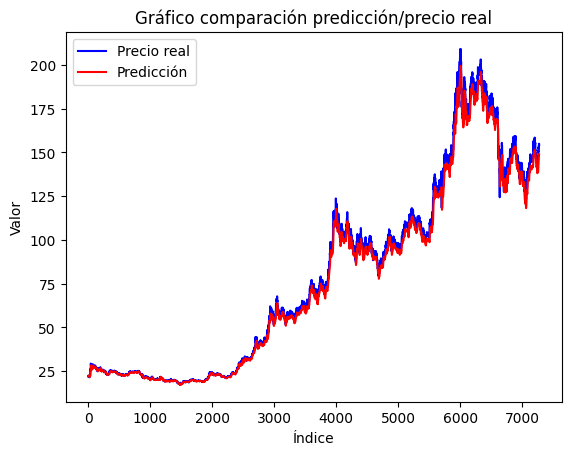

In [16]:
Valirpr = []
for i in range(7,df_vali.shape[0]):
    Valirpr.append(df_vali.iloc[i].close)
plt.plot(Valirpr, color='blue', label='Precio real')  # Línea azul
plt.plot(y_pred, color='red', label='Predicción')   # Línea roja
plt.title('Gráfico comparación predicción/precio real')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend() 

plt.show()

In [17]:
y_pred_aux=[]
for elem in y_pred:
    y_pred_aux.append(elem[0])
y_pred_aux = np.array(y_pred_aux)

In [18]:
suma = 0
n = len(Valirpr)
mae = np.mean(np.abs(Valirpr - y_pred_aux))
print("El error medio absoluto es: " + str(mae))
for i in range(0,n):
    suma = abs(y_pred_aux[i] - Valirpr[i])/Valirpr[i] +  suma
error_medio = suma/n
emp = error_medio*100 # error medio en porcentaje
print("El error medio porcentualemente es: " + str(emp))

El error medio absoluto es: 2.508740654710266
El error medio porcentualemente es: 2.667448605347697


In [19]:
df_test_aux = df_test[['open', 'high', 'low', 'close', 'value']].values
X_test, y_test= create_sequences(df_test_aux, 7)
X_test

array([[[154.35, 154.5 , 153.45, 154.1 ,  66.  ],
        [154.1 , 154.8 , 153.25, 154.15,  66.  ],
        [154.15, 154.3 , 153.25, 154.15,  66.  ],
        ...,
        [155.05, 155.4 , 153.1 , 153.3 ,  66.  ],
        [153.3 , 153.7 , 152.45, 153.05,  66.  ],
        [153.05, 153.25, 145.75, 147.5 ,  66.  ]],

       [[154.1 , 154.8 , 153.25, 154.15,  66.  ],
        [154.15, 154.3 , 153.25, 154.15,  66.  ],
        [154.15, 155.2 , 153.  , 155.05,  66.  ],
        ...,
        [153.3 , 153.7 , 152.45, 153.05,  66.  ],
        [153.05, 153.25, 145.75, 147.5 ,  66.  ],
        [147.5 , 148.65, 145.35, 146.95,  66.  ]],

       [[154.15, 154.3 , 153.25, 154.15,  66.  ],
        [154.15, 155.2 , 153.  , 155.05,  66.  ],
        [155.05, 155.4 , 153.1 , 153.3 ,  66.  ],
        ...,
        [153.05, 153.25, 145.75, 147.5 ,  66.  ],
        [147.5 , 148.65, 145.35, 146.95,  66.  ],
        [146.95, 148.8 , 145.15, 148.  ,  66.  ]],

       ...,

       [[143.3 , 145.1 , 142.7 , 145.05,  

In [20]:
X_testR = []
for i in X_test:
    aux = []
    for r in range(0, 7):
        for elem in i[r]:
            aux.append(elem)
    X_testR.append(aux)       
X_testR = np.array(X_testR) 

In [21]:
y_predT = model.predict(X_testR)
y_predT

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


array([[148.3425 ],
       [147.23029],
       [145.93011],
       ...,
       [139.08429],
       [139.06593],
       [139.28302]], dtype=float32)

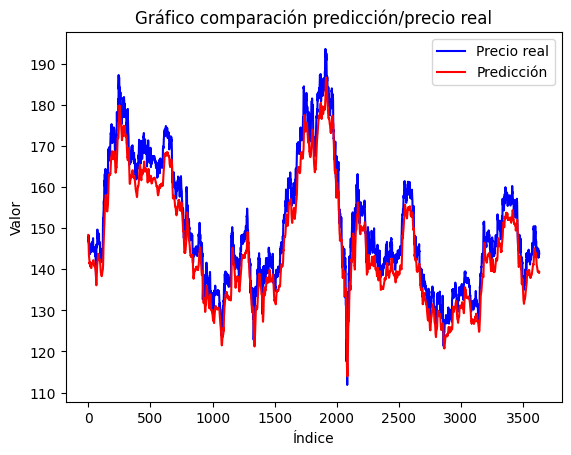

In [22]:
Testrpr = []
for i in range(7,df_test.shape[0]):
    Testrpr.append(df_test.iloc[i].close)
plt.plot(Testrpr, color='blue', label='Precio real')  # Línea azul
plt.plot(y_predT, color='red', label='Predicción')   # Línea roja
plt.title('Gráfico comparación predicción/precio real')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend() 

plt.show()

In [23]:
y_pred_auxT=[]
for elem in y_predT:
    y_pred_auxT.append(elem[0])
y_pred_auxT = np.array(y_pred_auxT)

In [24]:
suma = 0
n = len(Testrpr)
mae = np.mean(np.abs(Testrpr - y_pred_auxT))
print("El error medio absoluto es: " + str(mae))
for i in range(0,n):
    suma = abs(y_pred_auxT[i] - Testrpr[i])/Testrpr[i] +  suma
error_medio = suma/n
emp = error_medio*100 # error medio en porcentaje
print("El error medio porcentualemente es: " + str(emp))

El error medio absoluto es: 4.618907290303234
El error medio porcentualemente es: 3.0548014098986624


In [25]:
#model.save('mi_modelo_densoIMC3_96.h5')

In [26]:
def eval(Valirpr, y_pred_aux):
    suma = 0
    n = len(Valirpr)
    for i in range(0,n):
        suma = abs(y_pred_aux[i] - Valirpr[i])/Valirpr[i] +  suma
    error_medio = suma/n
    emp = error_medio*100 # error medio en porcentaje
    return emp

In [27]:
def rpr_prep(df):
    Testrpr = []
    for i in range(7,df.shape[0]):
        Testrpr.append(df.iloc[i].close)
    return Testrpr

In [28]:
def y_aux_prep(y_predT):
    y_pred_auxT=[]
    for elem in y_predT:
        y_pred_auxT.append(elem[0])
    y_pred_auxT = np.array(y_pred_auxT)
    return y_pred_auxT

In [41]:
def trainDenso(model, X_trainR, y_train, X_valiR, y_vali, X_testR):
    mejor_valor = 100.0
    epoc_list = [3, 5, 7, 10, 13, 16, 20, 24]
    batch_list = [4, 6, 8, 10, 12, 16, 20, 24, 28, 32, 36, 48, 56, 64, 80, 96, 112, 128, 140, 160, 180, 200, 228, 256]
    for e in epoc_list:
        for b in batch_list:
            for i in range(0, 50):
                history = model.fit(X_trainR, y_train, epochs=e, batch_size=b, validation_data=(X_valiR, y_vali), shuffle=False)
                y_pred = model.predict(X_testR)
                valor = eval(rpr_prep(df_test), y_aux_prep(y_pred))
                if valor < mejor_valor and valor < 1.0:
                    mejor_valor = valor
                    stri = "modelos_densos4capas\mi_modelo_densoICM" + str(e) + "_" + str(b) + "_" + str(round(valor, 4)) + ".h5"
                    model.save(stri)

In [42]:
trainDenso(model, X_trainR, y_train, X_valiR, y_vali, X_testR)

Epoch 1/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 648us/step - loss: 5.8698 - val_loss: 6.1936
Epoch 2/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 641us/step - loss: 5.8316 - val_loss: 6.2228
Epoch 3/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 649us/step - loss: 5.4990 - val_loss: 5.8556
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 659us/step - loss: 5.7310 - val_loss: 6.2607
Epoch 2/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 643us/step - loss: 5.9460 - val_loss: 6.2991
Epoch 3/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 649us/step - loss: 5.8328 - val_loss: 6.4581
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Epoch 1/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 644us/step - loss: 5.8634 - val_loss: 6.4668
Epoch 2/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 639us/step - loss: 5.7810 - val_loss: 6.6344
Epoch 3/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 645us/step - loss: 5.8312 - val_loss: 6.3464
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
Epoch 1/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 4s 648us/step - loss: 5.9669 

Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 1.8972 - val_loss: 0.9543
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - loss: 1.8593 - val_loss: 0.9485
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 1.8795 - val_loss: 0.9470
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - loss: 1.8826 - val_loss: 0.9546
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 1.8792 - val_loss: 0.9219
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 1.8901 - val_loss: 0.9479
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 1.8426 - val_loss: 0.8895
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - loss: 1.8282 - val_loss: 0.9025
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 1.8006 - val_loss: 0.8835
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - loss: 1.8360 - val_loss: 0.9202
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - loss: 1.8023 - val_loss: 0.9507
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - loss: 1.8369 - val_loss: 0.9578
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 1.8973 - val_loss: 0.9811
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - loss: 1.8913 - val_loss: 0.9336
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - loss: 1.9087 - val_loss: 0.9530
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 1.9322 - val_loss: 0.9664
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - loss: 1.9461 - val_loss: 0.9900
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 1.9555 - val_loss: 0.9540
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 1.9477 

Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - loss: 2.0195 - val_loss: 0.8897
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - loss: 2.1138 - val_loss: 0.8909
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 1.9523 - val_loss: 0.9405
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 2.1355 - val_loss: 0.9085
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - loss: 2.0732 - val_loss: 0.8648
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 2.0630 - val_loss: 0.8933
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - loss: 2.0169 - val_loss: 0.8720
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 2.0756 - val_loss: 0.9324
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - loss: 2.0441 - val_loss: 0.8693
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 2.0497 - val_loss: 0.8836
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 2.0635 - val_loss: 0.9379
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 2.1313 - val_loss: 0.9224
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 2.0615 - val_loss: 0.8781
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 2.1640 - val_loss: 0.8927
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 2.0831 - val_loss: 0.9170
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 2.0072 - val_loss: 0.8514
Epoch 2/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 2.1563 - val_loss: 0.9081
Epoch 3/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 1.9815 - val_loss: 0.9036
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 2.1134 

Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - loss: 1.9573 - val_loss: 0.8550
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - loss: 1.9713 - val_loss: 0.8801
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 1.8276 - val_loss: 0.8272
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 1.9120 - val_loss: 0.8468
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 2.0355 - val_loss: 0.8767
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 2.0529 - val_loss: 0.8990
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - loss: 1.9947 - val_loss: 0.9017
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - loss: 2.0448 - val_loss: 0.8590
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - loss: 1.9002 - val_loss: 0.8220
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 2.0010 - val_loss: 0.8533
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 2.0046 - val_loss: 0.8444
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - loss: 1.9338 - val_loss: 0.8471
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 1.9157 - val_loss: 0.8445
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - loss: 1.9480 - val_loss: 0.8332
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 2.0288 - val_loss: 0.8701
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 2.0009 - val_loss: 0.8529
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 1.9302 - val_loss: 0.8316
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 1.9504 - val_loss: 0.8374
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 1.9140 - val_loss: 0.8327
E

Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - loss: 1.8746 - val_loss: 0.8260
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 1.8827 - val_loss: 0.8236
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 1.8713 - val_loss: 0.8179
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - loss: 1.8709 - val_loss: 0.8083
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 1.8416 - val_loss: 0.8162
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 1.7661 - val_loss: 0.7900
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 1.8666 - val_loss: 0.7976
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 1.8641 - val_loss: 0.8157
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - loss: 1.8604 - val_loss: 0.8372
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 1.8688 - val_loss: 0.8414
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - loss: 1.9175 - val_loss: 0.8211
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 1.7995 - val_loss: 0.8301
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 1.9203 - val_loss: 0.8689
Epoch 2/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - loss: 2.0069 - val_loss: 0.8609
Epoch 3/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 1.9840 - val_loss: 0.8697
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
Epoch 1/3
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - loss: 1.9631 - val_loss: 0.8724
E

Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - loss: 2.0644 - val_loss: 0.7968
Epoch 2/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 2.0542 - val_loss: 0.8052
Epoch 3/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 2.0626 - val_loss: 0.7870
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 2.0577 - val_loss: 0.8087
Epoch 2/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 2.0231 - val_loss: 0.7873
Epoch 3/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - loss: 2.0301 - val_loss: 0.7914
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - loss: 2.0064 - val_loss: 0.7864
Epoch 2/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 1.9872 - val_loss: 0.7933
Epoch 3/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - loss: 2.0397 - val_loss: 0.7965
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - loss: 2.0027 - val_loss: 0.8152
E

Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 2.0531 - val_loss: 0.7893
Epoch 2/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 2.0145 - val_loss: 0.7787
Epoch 3/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 1.9966 - val_loss: 0.7797
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 2.0150 - val_loss: 0.7877
Epoch 2/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - loss: 2.0301 - val_loss: 0.7852
Epoch 3/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 2.0302 - val_loss: 0.7859
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 1.9990 - val_loss: 0.8128
Epoch 2/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - loss: 1.9946 - val_loss: 0.7832
Epoch 3/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - loss: 2.0112 - val_loss: 0.8037
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 2.0093 - val_loss: 0.7857
Epoch 2/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 2.0170 - val_loss: 0.7848
Epoch 3/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 2.0186 - val_loss: 0.7923
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
Epoch 1/3
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - loss: 2.0010 - val_loss: 0.7871
E

Epoch 1/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 2.0852 - val_loss: 0.7886
Epoch 2/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 2.0644 - val_loss: 0.7925
Epoch 3/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - loss: 2.1171 - val_loss: 0.7904
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 2.0980 - val_loss: 0.7868
Epoch 2/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - loss: 2.0606 - val_loss: 0.7845
Epoch 3/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 2.0381 - val_loss: 0.7833
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
Epoch 1/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - loss: 2.0084 - val_loss: 0.7841
Epoch 2/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - loss: 2.0358 - val_loss: 0.7815
Epoch 3/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - loss: 2.0220 - val_loss: 0.7808
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


Epoch 1/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 1.9880 - val_loss: 0.7740
Epoch 2/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - loss: 1.9359 - val_loss: 0.7728
Epoch 3/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 1.9257 - val_loss: 0.7857
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


Epoch 1/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - loss: 1.9021 - val_loss: 0.7875
Epoch 2/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 1.9423 - val_loss: 0.7700
Epoch 3/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 1.8648 - val_loss: 0.7809
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - loss: 1.9227 - val_loss: 0.7847
Epoch 2/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - loss: 1.9262 - val_loss: 0.7729
Epoch 3/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - loss: 1.9265 - val_loss: 0.7731
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
Epoch 1/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 1.9286 - val_loss: 0.7853
Epoch 2/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - loss: 1.9495 - val_loss: 0.7783
Epoch 3/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - loss: 1.8925 - val_loss: 0.7795
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
Epoch 1/3
708/708 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 1.9886 - val_loss: 0.7909
E

Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 1.5089 - val_loss: 0.7665
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.5412 - val_loss: 0.7644
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.5187 - val_loss: 0.7706
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 1.5625 - val_loss: 0.7659
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.5376 - val_loss: 0.7706
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 1.5497 - val_loss: 0.7655
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 1.5503 - val_loss: 0.7679
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.5507 - val_loss: 0.7639
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.5482 - val_loss: 0.7677
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1.5525 - val_loss: 0.7649
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 1.5473 - val_loss: 0.7638
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.5269 - val_loss: 0.7700
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 1.6249 - val_loss: 0.7666
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 1.5744 - val_loss: 0.7625
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.5567 - val_loss: 0.7617
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 1.5606 - val_loss: 0.7617
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 1.5597 - val_loss: 0.7609
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.5450 - val_loss: 0.7633
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.5383 - val_loss: 0.7654
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.5428 - val_loss: 0.7601
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 1.4953 - val_loss: 0.7667
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 1.6163 - val_loss: 0.7653
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.5926 - val_loss: 0.7628
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.5826 - val_loss: 0.7647
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 1.5881 - val_loss: 0.7631
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.5795 - val_loss: 0.7639
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.5823 - val_loss: 0.7641
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.5621 - val_loss: 0.7635
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.5695 - val_loss: 0.7610
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 1.5648 - val_loss: 0.7653
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 1.5557 - val_loss: 0.7646
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.5493 - val_loss: 0.7650
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.5630 - val_loss: 0.7647
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 1.5625 - val_loss: 0.7634
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.5568 - val_loss: 0.7642
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.5643 - val_loss: 0.7618
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 1.5283 - val_loss: 0.7615
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.6763 - val_loss: 0.7620
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.6930 - val_loss: 0.7631
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.7638 - val_loss: 0.7659
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.8493 - val_loss: 0.7653
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.9346 - val_loss: 0.7688
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 2.0636 - val_loss: 0.7638
E

Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.5231 - val_loss: 0.7646
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 1.5516 - val_loss: 0.7629
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.5448 - val_loss: 0.7653
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 1.5113 - val_loss: 0.7619
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.5699 - val_loss: 0.7618
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.5642 - val_loss: 0.7671
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.5241 - val_loss: 0.7614
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 1.6496 - val_loss: 0.7608
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.6457 - val_loss: 0.7605
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 1.6014 - val_loss: 0.7628
E

Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.6728 - val_loss: 0.7599
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 1.6809 - val_loss: 0.7611
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.6594 - val_loss: 0.7603
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.6884 - val_loss: 0.7621
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.8609 - val_loss: 0.7702
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 2.0394 - val_loss: 0.7663
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 2.0862 - val_loss: 0.7610
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.9715 - val_loss: 0.7618
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 1.9889 - val_loss: 0.7726
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 2.2965 - val_loss: 0.7685
E

Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 1.6661 - val_loss: 0.7584
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 1.7441 - val_loss: 0.7590
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 1.8136 - val_loss: 0.7616
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 1.9175 - val_loss: 0.7599
Epoch 2/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1.8888 - val_loss: 0.7586
Epoch 3/3
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.8504 - val_loss: 0.7588
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 1.9242 - val_loss: 0.8877
Epoch 2/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 2.5800 - val_loss: 0.9171
Epoch 3/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 3.2748 - val_loss: 0.8420
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
Epoch 1/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 1.9332 - val_loss: 0.8637
E

Epoch 1/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 1.4690 - val_loss: 0.7550
Epoch 2/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 1.5174 - val_loss: 0.7553
Epoch 3/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 1.5050 - val_loss: 0.7635
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
Epoch 1/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 1.4964 - val_loss: 0.7661
Epoch 2/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 1.4936 - val_loss: 0.7728
Epoch 3/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1.5124 - val_loss: 0.7648
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
Epoch 1/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 1.5249 - val_loss: 0.7764
Epoch 2/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.4511 - val_loss: 0.7748
Epoch 3/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 1.4708 - val_loss: 0.7718
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
Epoch 1/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 1.5069 - val_loss: 0.7675
E

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8332 - val_loss: 0.7881
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1.8301 - val_loss: 0.7900
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 1.8169 - val_loss: 0.7906
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8192 - val_loss: 0.7909
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 1.8004 - val_loss: 0.7926
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 1.7854 - val_loss: 0.7917
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7861 - val_loss: 0.7842
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 1.7793 - val_loss: 0.7775
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 1.7666 - val_loss: 0.7696
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7524 - val_loss: 0.7692
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1.7509 - val_loss: 0.7677
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 1.7537 - val_loss: 0.7688
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 1.7495 - val_loss: 0.7689
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 1.7466 - val_loss: 0.7681
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.7470 - val_loss: 0.7842
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7529 - val_loss: 0.7762
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 1.7395 - val_loss: 0.7812
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.7422 - val_loss: 0.7789
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7420 - val_loss: 0.7822
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 1.7318 - val_loss: 0.7743
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.7279 - val_loss: 0.7844
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 1.7348 - val_loss: 0.7731
Epoch

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6957 - val_loss: 0.7618
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 1.6973 - val_loss: 0.7641
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 1.6931 - val_loss: 0.7603
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 1.6993 - val_loss: 0.7634
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 1.6930 - val_loss: 0.7660
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.6962 - val_loss: 0.7641
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6953 - val_loss: 0.7679
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.6914 - val_loss: 0.7623
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.6931 - val_loss: 0.7606
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6896 - val_loss: 0.7646
Epoch 2

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 1.6919 - val_loss: 0.7662
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 1.6927 - val_loss: 0.7675
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 1.6950 - val_loss: 0.7635
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6923 - val_loss: 0.7644
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 1.6922 - val_loss: 0.7705
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.6973 - val_loss: 0.7609
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6904 - val_loss: 0.7670
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1.6910 - val_loss: 0.7664
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 1.6911 - val_loss: 0.7664
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6954 - val_loss: 0.7663
Epoch 2

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 1.6899 - val_loss: 0.7676
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 1.6964 - val_loss: 0.7658
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 1.6909 - val_loss: 0.7665
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6957 - val_loss: 0.7648
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.6922 - val_loss: 0.7646
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 1.6878 - val_loss: 0.7603
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6868 - val_loss: 0.7594
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.6822 - val_loss: 0.7643
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 1.7004 - val_loss: 0.7627
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6883 - val_loss: 0.7657
Epoch 2

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 1.6910 - val_loss: 0.7654
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.6917 - val_loss: 0.7638
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 1.6970 - val_loss: 0.7609
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 1.6901 - val_loss: 0.7632
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 1.6921 - val_loss: 0.7648
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 1.6950 - val_loss: 0.7728
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6989 - val_loss: 0.7684
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 1.6955 - val_loss: 0.7752
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 1.6987 - val_loss: 0.7681
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6923 - val_loss: 0.7646
Epoch

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 1.6996 - val_loss: 0.7653
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6975 - val_loss: 0.7664
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.6947 - val_loss: 0.7643
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 1.6899 - val_loss: 0.7620
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.6957 - val_loss: 0.7599
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.7015 - val_loss: 0.7644
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6937 - val_loss: 0.7669
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 1.6934 - val_loss: 0.7657
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.6948 - val_loss: 0.7712
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6942 - val_loss: 0.7589
Epoch 2

KeyboardInterrupt: 

# Entrenamos un modelo LSTM

In [31]:
from tensorflow.keras.layers import LSTM

In [33]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(64, activation='relu', input_shape=(7, 5), return_sequences=True))
modelLSTM.add(LSTM(64, activation='relu'))
modelLSTM.add(Dense(1))

In [34]:
modelLSTM.compile(optimizer='adam', loss='mape')

In [38]:
historyLSTM = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_vali, y_vali), shuffle=False)

Epoch 1/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.8635 - val_loss: 2.7180
Epoch 2/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.7135 - val_loss: 2.7441
Epoch 3/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.6973 - val_loss: 2.7463
Epoch 4/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.6404 - val_loss: 2.6740
Epoch 5/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.4634 - val_loss: 2.6206
Epoch 6/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.4007 - val_loss: 2.2800
Epoch 7/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.2457 - val_loss: 2.2633
Epoch 8/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.6125 - val_loss: 2.1846
Epoch 9/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.7975 - val_loss: 2.2030
Epoch 10/10
3185/3185 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.7025 - val_loss: 1.9446


In [64]:
y_predLSTM = modelLSTM.predict(X_vali)
y_predLSTM

228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[ 22.167841],
       [ 22.17166 ],
       [ 22.149292],
       ...,
       [148.19757 ],
       [147.32751 ],
       [149.51529 ]], dtype=float32)

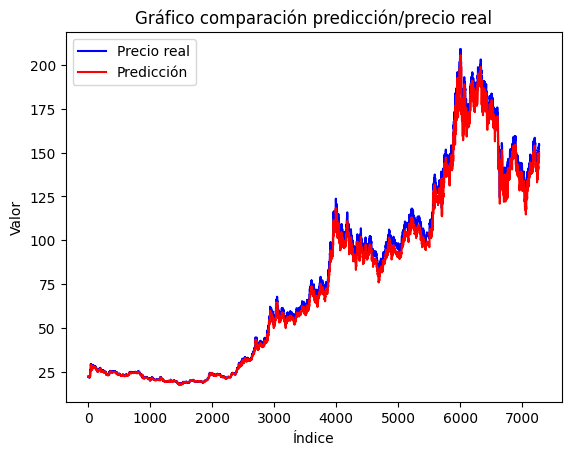

In [65]:
Valirpr = []
for i in range(7,df_vali.shape[0]):
    Valirpr.append(df_vali.iloc[i].close)
plt.plot(Valirpr, color='blue', label='Precio real')  # Línea azul
plt.plot(y_predLSTM, color='red', label='Predicción')   # Línea roja
plt.title('Gráfico comparación predicción/precio real')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend() 

plt.show()

In [66]:
y_pred_auxLSTM=[]
for elem in y_predLSTM:
    y_pred_auxLSTM.append(elem[0])
y_pred_auxLSTM = np.array(y_pred_auxLSTM)

In [67]:
suma = 0
n = len(Valirpr)
mae = np.mean(np.abs(Valirpr - y_pred_auxLSTM))
print("El error medio absoluto es: " + str(mae))
for i in range(0,n):
    suma = abs(y_pred_auxLSTM[i] - Valirpr[i])/Valirpr[i] +  suma
error_medio = suma/n
emp = error_medio*100 # error medio en porcentaje
print("El error medio porcentualemente es: " + str(emp))

El error medio absoluto es: 3.0411879671795177
El error medio porcentualemente es: 3.0564422218392946


Probamos los datos de test

In [68]:
df_test_aux = df_test[['open', 'high', 'low', 'close', 'value']].values
X_test, y_test = create_sequences(df_test_aux, 7)
X_test

array([[[154.35, 154.5 , 153.45, 154.1 ,  66.  ],
        [154.1 , 154.8 , 153.25, 154.15,  66.  ],
        [154.15, 154.3 , 153.25, 154.15,  66.  ],
        ...,
        [155.05, 155.4 , 153.1 , 153.3 ,  66.  ],
        [153.3 , 153.7 , 152.45, 153.05,  66.  ],
        [153.05, 153.25, 145.75, 147.5 ,  66.  ]],

       [[154.1 , 154.8 , 153.25, 154.15,  66.  ],
        [154.15, 154.3 , 153.25, 154.15,  66.  ],
        [154.15, 155.2 , 153.  , 155.05,  66.  ],
        ...,
        [153.3 , 153.7 , 152.45, 153.05,  66.  ],
        [153.05, 153.25, 145.75, 147.5 ,  66.  ],
        [147.5 , 148.65, 145.35, 146.95,  66.  ]],

       [[154.15, 154.3 , 153.25, 154.15,  66.  ],
        [154.15, 155.2 , 153.  , 155.05,  66.  ],
        [155.05, 155.4 , 153.1 , 153.3 ,  66.  ],
        ...,
        [153.05, 153.25, 145.75, 147.5 ,  66.  ],
        [147.5 , 148.65, 145.35, 146.95,  66.  ],
        [146.95, 148.8 , 145.15, 148.  ,  66.  ]],

       ...,

       [[143.3 , 145.1 , 142.7 , 145.05,  

In [69]:
y_predLSTMt = modelLSTM.predict(X_test)
y_predLSTMt

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


array([[141.73935],
       [138.24713],
       [140.69339],
       ...,
       [138.29184],
       [139.25269],
       [138.8168 ]], dtype=float32)

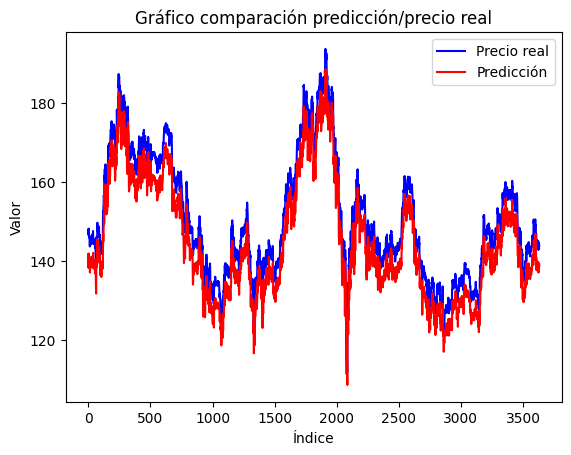

In [70]:
Testrpr = []
for i in range(7,df_test.shape[0]):
    Testrpr.append(df_test.iloc[i].close)
plt.plot(Testrpr, color='blue', label='Precio real')  # Línea azul
plt.plot(y_predLSTMt, color='red', label='Predicción')   # Línea roja
plt.title('Gráfico comparación predicción/precio real')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend() 

plt.show()

In [71]:
y_pred_auxLSTM=[]
for elem in y_predLSTMt:
    y_pred_auxLSTM.append(elem[0])
y_pred_auxLSTM = np.array(y_pred_auxLSTM)

In [72]:
suma = 0
n = len(Testrpr)
mae = np.mean(np.abs(Testrpr - y_pred_auxLSTM))
print("El error medio absoluto es: " + str(mae))
for i in range(0,n):
    suma = abs(y_pred_auxLSTM[i] - Testrpr[i])/Testrpr[i] +  suma
error_medio = suma/n
emp = error_medio*100 # error medio en porcentaje
print("El error medio porcentualemente es: " + str(emp))

El error medio absoluto es: 5.666565995489448
El error medio porcentualemente es: 3.7825047684562567


In [73]:
#modelLSTM.save('mi_modelo_lstmICM10_32.h5')

In [74]:
def eval(Valirpr, y_pred_aux):
    suma = 0
    n = len(Valirpr)
    for i in range(0,n):
        suma = abs(y_pred_aux[i] - Valirpr[i])/Valirpr[i] +  suma
    error_medio = suma/n
    emp = error_medio*100 # error medio en porcentaje
    return emp

In [75]:
def rpr_prep(df):
    Testrpr = []
    for i in range(7,df.shape[0]):
        Testrpr.append(df.iloc[i].close)
    return Testrpr

In [76]:
def y_aux_prep(y_predLSTMt):
    y_pred_auxLSTM=[]
    for elem in y_predLSTMt:
        y_pred_auxLSTM.append(elem[0])
    y_pred_auxLSTM = np.array(y_pred_auxLSTM)
    return y_pred_auxLSTM

In [79]:
def trainLSTM(modelLSTM, X_train, y_train, X_vali, y_vali, X_test):
    epoc_list = [3, 5, 7, 10, 13, 16, 20, 24]
    batch_list = [4, 6, 8, 10, 12, 16, 20, 24, 28, 32, 36, 48, 56, 64, 80, 96, 112, 128, 140, 160, 180, 200, 228, 256]
    mejor_valor = 100.0
    for e in epoc_list:
        for b in batch_list:
            for i in range(0, 25):
                historyLSTM = modelLSTM.fit(X_train, y_train, epochs=e, batch_size=b, validation_data=(X_vali, y_vali), shuffle=False)
                y_predLSTM = modelLSTM.predict(X_test)
                valor = eval(rpr_prep(df_test), y_aux_prep(y_predLSTM))
                if valor < mejor_valor and valor < 1.0:
                    mejor_valor = valor
                    stri = "modelos_lstm\mi_modelo_lstmICM" + str(e) + "_" + str(b) + "_" + str(round(valor, 4)) + ".h5"
                    modelLSTM.save(stri)
                    
    
    
    
        
    

In [80]:
trainLSTM(modelLSTM, X_train, y_train, X_vali, y_vali, X_test)

Epoch 1/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.2453 - val_loss: 4.9477
Epoch 2/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.7259 - val_loss: 4.4435
Epoch 3/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.7099 - val_loss: 3.3490
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
Epoch 1/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.3229 - val_loss: 3.5366
Epoch 2/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.7426 - val_loss: 3.0821
Epoch 3/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.8320 - val_loss: 3.0218
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
Epoch 1/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.7206 - val_loss: 2.4756
Epoch 2/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.6063 - val_loss: 3.0037
Epoch 3/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.6801 - val_loss: 2.9658
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
Epoch 1/3
6369/6369 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.9623 - val_loss: 2.8766
E

Epoch 1/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2.1560 - val_loss: 2.6274
Epoch 2/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1.9493 - val_loss: 3.0312
Epoch 3/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1.9426 - val_loss: 3.0970
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
Epoch 1/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.9380 - val_loss: 3.2247
Epoch 2/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.9054 - val_loss: 3.3054
Epoch 3/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.9301 - val_loss: 3.2549
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
Epoch 1/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.0394 - val_loss: 2.0157
Epoch 2/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.9469 - val_loss: 2.7906
Epoch 3/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.8918 - val_loss: 3.2418
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
Epoch 1/3
4246/4246 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.0394 - val_loss: 3.3244
E

Epoch 1/3
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7734 - val_loss: 0.7962
Epoch 2/3
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7584 - val_loss: 0.8089
Epoch 3/3
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7475 - val_loss: 0.9659
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
Epoch 1/3
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7562 - val_loss: 1.0046
Epoch 2/3
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.7782 - val_loss: 0.9976
Epoch 3/3
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8177 - val_loss: 1.0027
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
Epoch 1/3
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8347 - val_loss: 0.9769
Epoch 2/3
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8158 - val_loss: 1.0630
Epoch 3/3
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7749 - val_loss: 1.0021
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
Epoch 1/3
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8488 - val_loss: 1.0209
E

Epoch 1/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5981 - val_loss: 0.8445
Epoch 2/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6105 - val_loss: 0.8468
Epoch 3/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5958 - val_loss: 0.8383
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
Epoch 1/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6716 - val_loss: 0.8332
Epoch 2/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5364 - val_loss: 0.8530
Epoch 3/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6693 - val_loss: 0.8527
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
Epoch 1/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6591 - val_loss: 0.8470
Epoch 2/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6980 - val_loss: 0.8493
Epoch 3/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6341 - val_loss: 0.8500
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Epoch 1/3
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6818 - val_loss: 0.8525
Epoch 2/3
490/490 ━━━

Epoch 1/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7679 - val_loss: 0.8376
Epoch 2/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7386 - val_loss: 0.8173
Epoch 3/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6305 - val_loss: 0.8377
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
Epoch 1/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6659 - val_loss: 0.8359
Epoch 2/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6359 - val_loss: 0.8186
Epoch 3/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5818 - val_loss: 0.8086
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Epoch 1/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5323 - val_loss: 0.8034
Epoch 2/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4914 - val_loss: 0.8001
Epoch 3/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6250 - val_loss: 0.8041
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
Epoch 1/3
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5077 - val_loss: 0.8119
Epoch 2/3
455/455 ━━━

Epoch 1/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5274 - val_loss: 0.8020
Epoch 2/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4373 - val_loss: 0.8076
Epoch 3/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5240 - val_loss: 0.8070
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
Epoch 1/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5104 - val_loss: 0.8004
Epoch 2/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5119 - val_loss: 0.8024
Epoch 3/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4722 - val_loss: 0.8012
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Epoch 1/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4744 - val_loss: 0.8005
Epoch 2/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4471 - val_loss: 0.8048
Epoch 3/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5734 - val_loss: 0.8041
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Epoch 1/3
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4735 - val_loss: 0.8039
Epoch 2/3
432/432 ━━━

Epoch 1/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4770 - val_loss: 0.8112
Epoch 2/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6127 - val_loss: 0.8015
Epoch 3/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4788 - val_loss: 0.8342
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
Epoch 1/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6753 - val_loss: 0.8090
Epoch 2/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4607 - val_loss: 0.8320
Epoch 3/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4941 - val_loss: 2.3085
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
Epoch 1/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9567 - val_loss: 0.9486
Epoch 2/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4095 - val_loss: 0.8109
Epoch 3/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0413 - val_loss: 0.8681
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
Epoch 1/3
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9044 - val_loss: 0.9293
Epoch 2/3
399/399 ━━━

Epoch 1/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3872 - val_loss: 0.7782
Epoch 2/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4404 - val_loss: 0.7690
Epoch 3/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4106 - val_loss: 0.7669
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
Epoch 1/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4781 - val_loss: 0.7647
Epoch 2/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4432 - val_loss: 0.7668
Epoch 3/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4588 - val_loss: 0.7721
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
Epoch 1/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4530 - val_loss: 0.7702
Epoch 2/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4635 - val_loss: 0.7767
Epoch 3/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4329 - val_loss: 0.7782
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
Epoch 1/3
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4910 - val_loss: 0.7698
Epoch 2/3
392/392 ━━━

Epoch 1/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3840 - val_loss: 0.7502
Epoch 2/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3956 - val_loss: 0.7504
Epoch 3/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5197 - val_loss: 0.7513
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
Epoch 1/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4727 - val_loss: 0.7575
Epoch 2/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4077 - val_loss: 0.7623
Epoch 3/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4051 - val_loss: 0.7551
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
Epoch 1/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3808 - val_loss: 0.7515
Epoch 2/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3872 - val_loss: 0.7530
Epoch 3/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3703 - val_loss: 0.7540
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
Epoch 1/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4082 - val_loss: 0.7524
Epoch 2/3
327/327 ━━━

Epoch 1/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4233 - val_loss: 0.7586
Epoch 2/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4103 - val_loss: 0.7572
Epoch 3/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4185 - val_loss: 0.7533
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
Epoch 1/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4411 - val_loss: 0.7756
Epoch 2/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4573 - val_loss: 0.7623
Epoch 3/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4194 - val_loss: 0.7574
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
Epoch 1/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3814 - val_loss: 0.7541
Epoch 2/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3948 - val_loss: 0.7541
Epoch 3/3
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4292 - val_loss: 0.7539
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
Epoch 1/3
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4895 - val_loss: 0.7926
Epoch 2/3
323/323 ━━━

KeyboardInterrupt: 